# TP : Auto-encodeurs variationnels

Dans ce TP, dans un premier temps, nous allons entraîner un modèle génératif de type d'auto-encodeur variationnel sur le jeu de données MNIST (chiffres manuscrits de 0 à 9). Dans un deuxième, temps nous allons essayer de générer des chiffres en échantiollannant dans l'espace latent.

In [8]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Définir l'architecture du VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encodeur
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 50)  # Moyenne mu
        self.fc22 = nn.Linear(400, 50)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(50, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Paramètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Chargement des données MNIST
train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

# Entraînement du modèle
for epoch in range(10):
    vae.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

Epoch 0, Loss: 170.7637250325521
Epoch 1, Loss: 127.88199431966146
Epoch 2, Loss: 117.87422428385416
Epoch 3, Loss: 113.28890102539063
Epoch 4, Loss: 110.73439812825521
Epoch 5, Loss: 109.21513318684896
Epoch 6, Loss: 108.17036665039062
Epoch 7, Loss: 107.37893937174479
Epoch 8, Loss: 106.88804614257812
Epoch 9, Loss: 106.40095991210937


## Exercices

* Rédiger un code Python qui permet d'échantillonner à partir de l'espace latent pour générer de nouvelles images.

Pour faire de l'inférence, nous n'avons pas besoin de faire passer le gradient à travers le processus d'échantillonnage, car nous ne faisons pas de rétropropagation.

On suppose que le modèle a été correctement entraîné et que l'espace latent suit la distribution Gaussienne. 

Donc, directement échantillonner de cette distribution sans avoir besoin de la reparamétrisation.

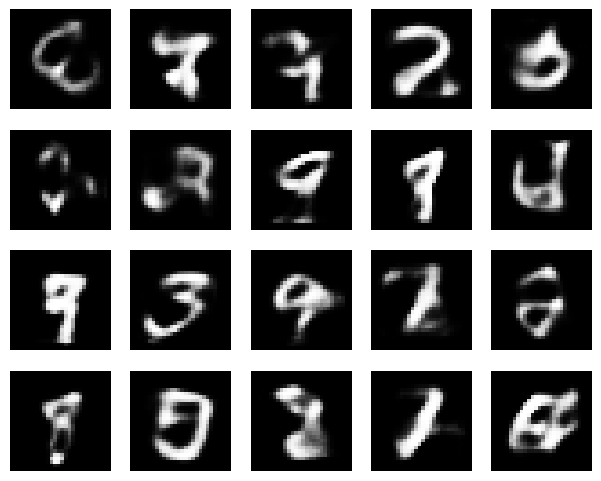

In [36]:
import matplotlib.pyplot as plt

def generate_images(vae, num_samples=20, latent_dim=50, image_size=(28, 28), images_per_row=5):
    vae.eval()

    z = torch.randn(num_samples, latent_dim).to(device)

    with torch.no_grad():
        generated_images = vae.decode(z)

    generated_images = generated_images.view(-1, *image_size)

    num_rows = num_samples // images_per_row + (0 if num_samples % images_per_row == 0 else 1)

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 1.5, num_rows * 1.5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_samples:
            ax.imshow(generated_images[i].cpu().numpy(), cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()

generate_images(vae)

### Changer la dimension de l'espace latent.
